In [ ]:
import pandas as pd 
pd.options.plotting.backend = 'plotly' # 'matplotlib' # 
pd.options.display.max_columns = 200
import plotly.express as px
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import shutil
import time
from glob import glob
from tqdm import tqdm
from collections import Counter

from IPython.core.display import clear_output
!pip install geopandas
!pip install -U folium matplotlib mapclassify
clear_output()
import geopandas as gpd

from shapely.geometry import Point, LineString

In [ ]:
road_data_folder = '/content/drive/MyDrive/nyc_data/road'

raw_road_data_folder = '/content/drive/MyDrive/nyc_data/road/raw'

# NYC Open Data

## DOT_Traffic_Speeds_NBE

### Preprocess the raw traffic speed data



In [ ]:
# df = pd.read_csv(raw_road_data_folder+'/nyc_open/DOT_Traffic_Speeds_NBE.csv',usecols = 'ID,SPEED,TRAVEL_TIME,DATA_AS_OF,LINK_POINTS,LINK_NAME,OWNER'.split(','))

# df['DATA_AS_OF'] = pd.to_datetime(df['DATA_AS_OF'])
# df = df[df['DATA_AS_OF']>='2014'] # remove date anamolies

# df = df.rename(columns={'ID':'LINK_ID'})

# id_and_field_pair_list = []
# for field in ['LINK_POINTS','OWNER','LINK_NAME']:
#   id_and_field_pair = df.groupby('LINK_ID')[field].apply(list).apply(lambda li: Counter(li).most_common(1)[0])
#   id_and_field_pair_list.append(id_and_field_pair)
# link_information = pd.concat(id_and_field_pair_list, axis=1).reset_index()
# link_information.to_csv(road_data_folder + '/link_information.csv', index=False)

# df = df.drop(['LINK_POINTS','OWNER','LINK_NAME'], axis=1)
# df = df.sort_values(['DATA_AS_OF','LINK_ID']).reset_index(drop = True)

# # df['dist'] = ((df['SPEED'] * df['TRAVEL_TIME'])/500).astype(int)
# # df.groupby('LINK_ID')['dist'].apply(lambda x: Counter(list(x)).most_common())
# # df = df.drop('dist', axis=1)

# # np.mean(df.loc[df.TRAVEL_TIME == 0,'SPEED'] == 0) # it is not possible to pass the road in no time
# # np.mean(df.loc[df.SPEED == 0,'TRAVEL_TIME'] == 0) # it is possible to have zero speed due to congestion / gridlock
# df = df[df['TRAVEL_TIME']>0]

# df.to_parquet(road_data_folder + '/dot_traffic_speeds.parquet')
# df.to_csv(road_data_folder + '/dot_traffic_speeds.csv', index=False)

In [ ]:
link_information = pd.read_csv(road_data_folder + '/link_information.csv')

In [ ]:
link_information['raw_coords'] = link_information['LINK_POINTS'].apply(lambda coords_string: coords_string.split())

In [ ]:
def extract_lat_lon_pair(pair_string):
  try:
    lat, lon = pair_string.split(',')
  except:
    print(pair_string)
    return (0, 0)
  try:
    lat = float(lat)
    lon = float(lon)
  except:
    print(pair_string)
    lat = 0
    lon = 0
  return (lon, lat)

In [ ]:
link_information['float_coords'] = link_information['raw_coords'].apply(lambda li: [extract_lat_lon_pair(x) for x in li])

In [ ]:
def get_non_deviated_coords(coords, threshold = 0.1):

  temp_coords = [coords[1]]+coords
  abs_diff = np.diff(temp_coords, axis=0).sum(axis=1)
  deviation_from_median = np.abs(abs_diff - np.median(abs_diff))
  non_deviated_coords = np.array(coords, dtype=object)[deviation_from_median<=0.02]

  return non_deviated_coords

In [ ]:
link_information['coords'] = link_information['float_coords'].apply(get_non_deviated_coords)

In [ ]:
# (link_information['float_coords'].apply(len) - link_information['coords'].apply(len))
# link_information['coords'].apply(len).value_counts()

In [ ]:
link_information['geometry'] = link_information['coords'].apply(lambda li: LineString([Point(pt) for pt in li]))

In [ ]:
geo_link_information = gpd.GeoDataFrame(link_information[['LINK_ID', 'LINK_NAME', 'OWNER', 'geometry']], geometry = 'geometry').set_crs('epsg:4326')

In [ ]:
geo_link_information.to_file(road_data_folder + '/link_information.geojson', driver = 'GeoJSON')

### Filter for the 2018-2021 period, select links with sufficient amount of entries


In [ ]:
dot_traffic_speeds = pd.read_parquet(road_data_folder + '/dot_traffic_speeds.parquet')

dot_traffic_speeds['DATA_AS_OF'].dt.date.value_counts().sort_index().plot(kind='bar')

In [ ]:
## Manual inspection shows that data for 2018, 2019, 2020, 2021 is complete. This data processing is done at the end of Q1 of 2022, and 2017 data is half the amount of that of 2018, so not included.
dot_traffic_speeds = dot_traffic_speeds[dot_traffic_speeds['DATA_AS_OF']>='2018']

In [ ]:
# ## Deprecated because using pandas resample functionality can mark the period where data is unavailable as missing, filtering out missing value or imputing can be a later decision
# # entry_count_at_each_link = (dot_traffic_speeds['LINK_ID'].value_counts()/1000).astype(int)*1000
# # entry_count_at_each_link.reset_index().LINK_ID.plot()
# ## Manual inspection discovers a drop at 117th link, using it as a cut-off (which is 3/4 of the total 153 links, 85% of the 138 links covering the 2018-2021 period)
# dot_traffic_speeds = dot_traffic_speeds[dot_traffic_speeds['LINK_ID'].isin(dot_traffic_speeds['LINK_ID'].value_counts()[:117].index.tolist())]
# dot_traffic_speeds = dot_traffic_speeds.reset_index(drop = True)  
# dot_traffic_speeds.to_parquet(road_data_folder + '/dot_traffic_speeds_2018_to_2021_at_117_links.parquet')

In [ ]:
dot_traffic_speeds = dot_traffic_speeds.set_index('DATA_AS_OF')
resampled_dot_traffic_speeds = pd.DataFrame()
for LINK_ID in tqdm(dot_traffic_speeds['LINK_ID'].unique().tolist()):
  this_link_df = dot_traffic_speeds.loc[dot_traffic_speeds['LINK_ID'] == LINK_ID]
  this_link_df_5min = this_link_df.resample('5min').mean()
  this_link_df_5min['LINK_ID'] = LINK_ID
  resampled_dot_traffic_speeds = resampled_dot_traffic_speeds.append(this_link_df_5min, ignore_index = False)

100%|██████████| 139/139 [00:50<00:00,  2.76it/s]


In [ ]:
resampled_dot_traffic_speeds.SPEED.round(0).value_counts().sort_index().plot(kind='bar')

In [ ]:
resampled_dot_traffic_speeds.to_parquet(road_data_folder + '/dot_traffic_speeds_resampled_5min.parquet')

## Volume at 15 minute interval

In [ ]:
atvc = pd.read_csv(raw_road_data_folder+'/nyc_open/Automated_Traffic_Volume_Counts.csv')

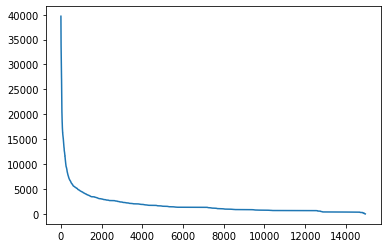

In [ ]:
plt.plot(atvc.SegmentID.value_counts().values)

In [ ]:
# atvc.SegmentID.value_counts().head(50)

In [ ]:
# atvc['M'].value_counts().sort_index().plot(kind='bar')

## Volume at hourly interval

In [ ]:
tvc = pd.read_csv(raw_road_data_folder+'/nyc_open/Traffic_Volume_Counts__2014-2020_.csv')

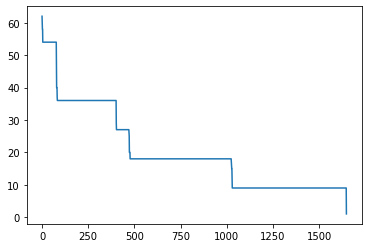

In [ ]:
plt.plot(tvc['Segment ID'].value_counts().values)

In [ ]:
tvc.Date.value_counts()

10/13/2019    391
10/12/2019    391
11/14/2020    314
11/15/2020    314
10/05/2019    291
             ... 
12/05/2020      1
02/16/2015      1
01/21/2017      1
01/20/2017      1
12/13/2020      1
Name: Date, Length: 486, dtype: int64

## Classification at hourly interval

In [ ]:
vcc = pd.read_csv(raw_road_data_folder+'/nyc_open/Vehicle_Classification_Counts__2014-2020_.csv')

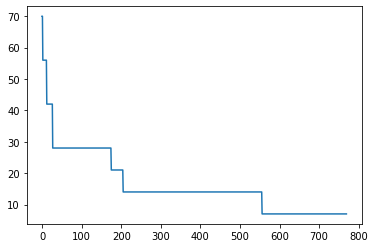

In [ ]:
plt.plot(vcc['SegmentID'].value_counts().values)

# Uber Movement Data

In [ ]:
# for p in tqdm(glob(raw_road_data_folder+'/uber_movement/*')):
#   os.system('unzip '+p)
#   time.sleep(2)

In [ ]:
uber_id_osm_id_matching_table = pd.DataFrame()
for p in tqdm(sorted(glob('/content/*.csv'))):
  df = pd.read_csv(p)
  uber_id_osm_id_matching_table = uber_id_osm_id_matching_table.append( df[['segment_id', 'start_junction_id', 'end_junction_id', 'osm_way_id', 'osm_start_node_id', 'osm_end_node_id']].drop_duplicates() , ignore_index = True).drop_duplicates()
  df = df[['year', 'month', 'day', 'hour', 'utc_timestamp', 
          'osm_way_id', 'osm_start_node_id', 'osm_end_node_id', 
          'speed_mph_mean', 'speed_mph_stddev']]
  df.to_parquet(raw_road_data_folder+'/uber_movement/'+p.split('/')[-1].replace('.csv','.parquet'))
  del df
uber_id_osm_id_matching_table.to_parquet(raw_road_data_folder+'/uber_movement/'+'uber_id_osm_id_matching_table.parquet')

In [ ]:
traffic_speed_2019Q3 = pd.DataFrame()
for p in sorted(glob('/content/drive/MyDrive/nyc_data/road/raw/uber_movement/movement-speeds-hourly-new-york-2019-[789].parquet')):  
  traffic_speed_2019Q3 = traffic_speed_2019Q3.append(pd.read_parquet(p), ignore_index=True)
traffic_speed_2019Q3.drop(['utc_timestamp'], axis=1, inplace=True)
traffic_speed_2019Q3['datetime'] = pd.to_datetime(traffic_speed_2019Q3[['year','month','day','hour']])
traffic_speed_2019Q3.drop(['year','month','day','hour'], axis=1, inplace=True)
traffic_speed_2019Q3['speed'] = (traffic_speed_2019Q3['speed_mph_mean']*1.60934).round(2)
traffic_speed_2019Q3['speed_stddev'] = (traffic_speed_2019Q3['speed_mph_stddev']*1.60934).round(2)
traffic_speed_2019Q3.drop(['speed_mph_mean','speed_mph_stddev'], axis=1, inplace=True)
traffic_speed_2019Q3.to_parquet('/content/drive/MyDrive/nyc_data/road/uber-movement-speeds-hourly-new-york-2019-Q3.parquet')

In [ ]:
traffic_speed_2019Q3 = pd.read_parquet('/content/drive/MyDrive/nyc_data/road/uber-movement-speeds-hourly-new-york-2019-Q3.parquet')
traffic_speed_2019Q3['day_of_week'] = traffic_speed_2019Q3['datetime'].dt.day_of_week
traffic_speed_2019Q3['hour'] = traffic_speed_2019Q3['datetime'].dt.hour
hourly_weekly_traffic_speed_2019Q3 = traffic_speed_2019Q3.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id','day_of_week','hour']).agg({'speed':'median'}).reset_index()
hourly_weekly_traffic_speed_2019Q3.to_parquet('/content/drive/MyDrive/nyc_data/road/hourly_weekly_traffic_speed_2019Q3.parquet')